In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/fall22/datamining/TrafficVolumePrediction/"

In [ ]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

In [ ]:
# Hyper parameters
########
num_of_feature = 4 # number of input features for LSTM and GRU network
past_observation = 12 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64,32,16]
return_sequence = [True, True, True,False]
batch_size = 64
num_of_epoch = 300



# Read dataset

In [ ]:
# Import Dataset

traffic_data = pd.read_csv(path+"dataset/Metro_Interstate_Traffic_Volume.csv")
traffic_data = traffic_data.set_index(pd.DatetimeIndex(traffic_data['date_time'])).rename(columns={"date_time": "ds"})
traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)

In [ ]:
traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159


In [ ]:
traffic_data = traffic_data.drop_duplicates()

In [ ]:
# Checking for any missing or empty value
traffic_data.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
ds                     0
traffic_volume         0
dtype: int64

# convert categorical to nominal data

In [ ]:
# Convert categorical value to numerical values. For holiday attribute, value will be within by 0 and 1. If it is holiday then 1 otherwise 0
label_encoder = preprocessing.LabelEncoder()
traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
traffic_data['weather_description'] = label_encoder.fit_transform(traffic_data['weather_description'])

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\1522180088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\1522180088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\1522180088.py:5: SettingWithCopyWarning: 
A value 

In [ ]:
traffic_data.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
count,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000
mean,0.001266,281.204995,0.334382,0.000222,49.365451,2.578642,16.540021,3259.618134
std,0.035557,13.338738,44.797033,0.008169,39.015213,2.784148,8.969561,1986.954465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,272.160000,0.000000,0.000000,1.000000,0.000000,10.000000,1192.500000
50%,0.000000,282.450000,0.000000,0.000000,64.000000,1.000000,17.000000,3379.000000
75%,0.000000,291.806000,0.000000,0.000000,90.000000,5.000000,27.000000,4933.000000
max,1.000000,310.070000,9831.300000,0.510000,100.000000,10.000000,37.000000,7280.000000


<AxesSubplot:xlabel='date_time'>

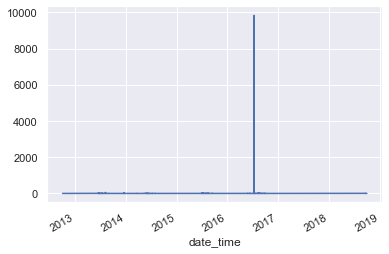

In [ ]:
#traffic_data['temp'].plot()
traffic_data['rain_1h'].plot()


<AxesSubplot:xlabel='date_time'>

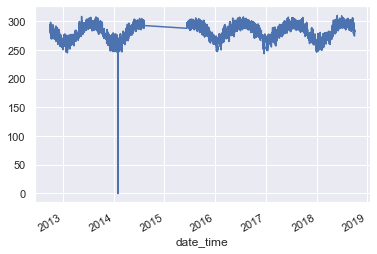

In [ ]:
traffic_data['temp'].plot()

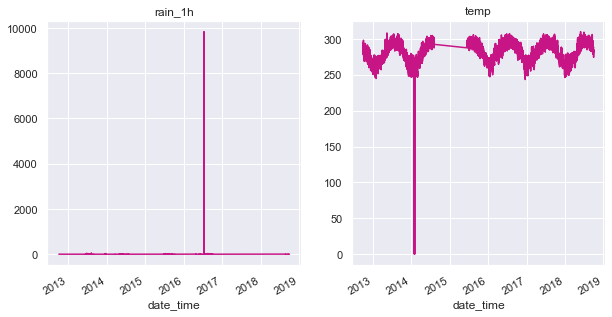

In [ ]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig(path+"reduced_feature_images/with_outlier.png", dpi=600)

In [ ]:
Q1 = traffic_data.quantile(0.25)
Q3 = traffic_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

holiday                   0.000
temp                     19.646
rain_1h                   0.000
snow_1h                   0.000
clouds_all               89.000
weather_main              5.000
weather_description      17.000
traffic_volume         3740.500
dtype: float64


In [ ]:
traffic_data=traffic_data[~((traffic_data['temp'] <(Q1['temp']-1.5*IQR['temp'])) | (traffic_data['temp'] >(Q1['temp']+1.5*IQR['temp'])))]
traffic_data=traffic_data[~((traffic_data['traffic_volume'] <(Q1['traffic_volume']-1.5*IQR['traffic_volume'])) | (traffic_data['traffic_volume'] >(Q1['traffic_volume']+1.5*IQR['traffic_volume'])))]

# Prepare training and testing data

<AxesSubplot:xlabel='date_time'>

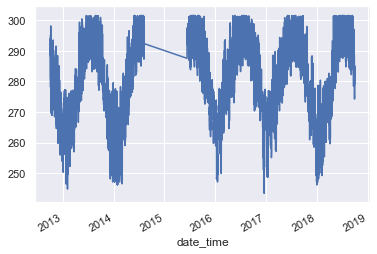

In [ ]:
# ploting traffic data to see to see any data imbalance
traffic_data['temp'].plot()

<AxesSubplot:xlabel='date_time'>

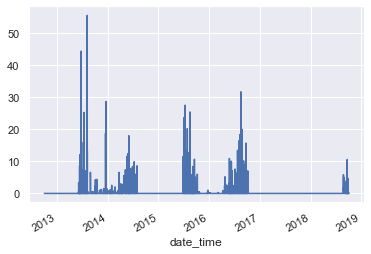

In [ ]:
traffic_data['rain_1h'].plot()

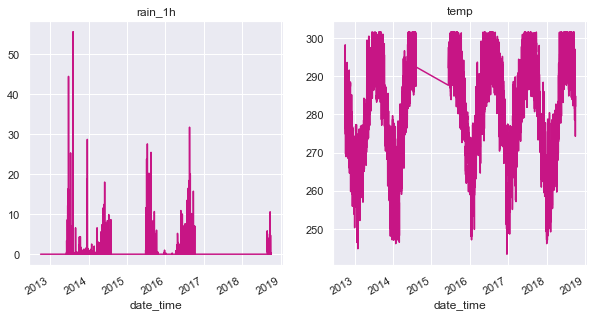

In [ ]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig(path+"reduced_feature_images/without_outlier.png", dpi=600)

In [ ]:

traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,0,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,0,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,0,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,0,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,0,283.45,0.0,0.0,75,1,2,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,0,282.76,0.0,0.0,90,1,19,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,0,282.73,0.0,0.0,90,10,21,2018-09-30 21:00:00,2159


In [ ]:
split_date = '2018-01-01'
train_data = traffic_data.loc[traffic_data.index <= split_date].copy()
test_data = traffic_data.loc[traffic_data.index > split_date].copy()

train_time = train_data["ds"]
test_time = test_data["ds"]

In [ ]:
train_data = train_data[["temp","rain_1h","clouds_all","traffic_volume"]]
test_data = test_data[["temp","rain_1h","clouds_all","traffic_volume"]]

In [ ]:
train_data

,temp,rain_1h,clouds_all,traffic_volume
date_time,,,,
2012-10-02 09:00:00,288.28,0.0,40,5545
2012-10-02 10:00:00,289.36,0.0,75,4516
2012-10-02 11:00:00,289.58,0.0,90,4767
2012-10-02 12:00:00,290.13,0.0,90,5026
2012-10-02 13:00:00,291.14,0.0,75,4918
...,...,...,...,...
2017-12-31 20:00:00,249.79,0.0,5,2731
2017-12-31 21:00:00,249.61,0.0,5,2483
2017-12-31 22:00:00,249.50,0.0,1,2041


In [ ]:
test_data

,temp,rain_1h,clouds_all,traffic_volume
date_time,,,,
2018-01-01 01:00:00,249.08,0.0,1,1408
2018-01-01 02:00:00,248.86,0.0,1,931
2018-01-01 03:00:00,248.72,0.0,1,585
2018-01-01 04:00:00,248.43,0.0,1,381
2018-01-01 05:00:00,248.07,0.0,1,434
...,...,...,...,...
2018-09-30 19:00:00,283.45,0.0,75,3543
2018-09-30 20:00:00,282.76,0.0,90,2781
2018-09-30 21:00:00,282.73,0.0,90,2159


In [ ]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)

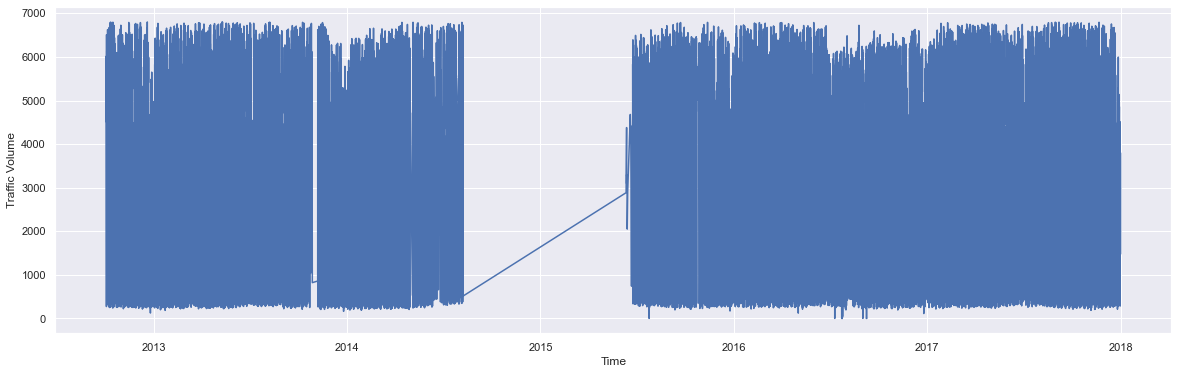

In [ ]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_time)
time_valid = np.array(test_time)

plt.figure(figsize=(20,6))
plot_series(time_train, x_train)

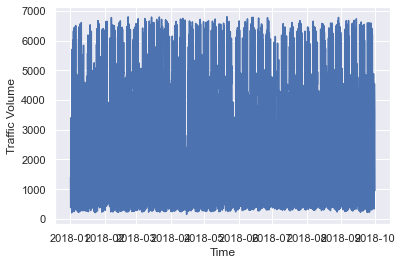

In [ ]:
plot_series(time_valid, x_valid)

In [ ]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data)
test_data_frame = pd.DataFrame(test_data_set)


In [ ]:
# Make data for the LSTM model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((39356, 24, 4), (39356,))

In [ ]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((7604, 24, 4), (7604,))

In [ ]:
# split data into train test and validation datase
from cgi import test


train_length = int(len(X)*0.9) # 80% trainging
validation_length = int(len(X)*.10) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

35420 3935 39355


In [ ]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)


(((35420, 24, 4), (35420,)), ((3936, 24, 4), (3936,)))

In [ ]:
#define LSTM model:


LSTM_Model = Sequential()
LSTM_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    LSTM_Model.add(LSTM(hidden_layers_unit[i], return_sequences=return_sequence[i]))
LSTM_Model.add(Dense(1))
LSTM_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001, decay=1e-5), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
LSTM_Model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 24, 64)            17664     
                                                                 
 lstm_13 (LSTM)              (None, 24, 32)            12416     
                                                                 
 lstm_14 (LSTM)              (None, 16)                3136      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 33,233
Trainable params: 33,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Define GRU MODEL
GRU_Model = Sequential()
GRU_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
GRU_Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 24, 64)            13440     
                                                                 
 gru_13 (GRU)                (None, 24, 32)            9408      
                                                                 
 gru_14 (GRU)                (None, 16)                2400      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25,265
Trainable params: 25,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_CheckPoint = ModelCheckpoint(path+'reduced_feature_model/model_lstm/', save_best_only=True)
GRU_CheckPoint = ModelCheckpoint(path+'reduced_feature_model/model_gru/', save_best_only=True)
earlyStop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, mode='min')


In [ ]:
# Train LSTM Model
LSTM_history = LSTM_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[LSTM_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

Epoch 1/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 29795.2070

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 53s 22ms/step - loss: 0.0585 - mean_absolute_error: 0.1940 - mean_absolute_percentage_error: 29785.1406 - val_loss: 0.0267 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error: 59.6615
Epoch 2/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 11954.2402

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 52s 24ms/step - loss: 0.0239 - mean_absolute_error: 0.1155 - mean_absolute_percentage_error: 11954.2402 - val_loss: 0.0124 - val_mean_absolute_error: 0.0807 - val_mean_absolute_percentage_error: 28.0811
Epoch 3/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 6162.5376

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 49s 22ms/step - loss: 0.0136 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 6160.4556 - val_loss: 0.0074 - val_mean_absolute_error: 0.0630 - val_mean_absolute_percentage_error: 23.8282
Epoch 4/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0701 - mean_absolute_percentage_error: 3688.1758

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 53s 24ms/step - loss: 0.0102 - mean_absolute_error: 0.0701 - mean_absolute_percentage_error: 3685.2913 - val_loss: 0.0064 - val_mean_absolute_error: 0.0602 - val_mean_absolute_percentage_error: 28.6031
Epoch 5/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0661 - mean_absolute_percentage_error: 4300.7051

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 50s 23ms/step - loss: 0.0094 - mean_absolute_error: 0.0661 - mean_absolute_percentage_error: 4300.7051 - val_loss: 0.0056 - val_mean_absolute_error: 0.0551 - val_mean_absolute_percentage_error: 22.4450
Epoch 6/100
2214/2214 [==============================] - 39s 18ms/step - loss: 0.0092 - mean_absolute_error: 0.0647 - mean_absolute_percentage_error: 4612.0967 - val_loss: 0.0070 - val_mean_absolute_error: 0.0651 - val_mean_absolute_percentage_error: 35.2254
Epoch 7/100
2211/2214 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 4424.2363

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 50s 23ms/step - loss: 0.0090 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 4418.7759 - val_loss: 0.0053 - val_mean_absolute_error: 0.0536 - val_mean_absolute_percentage_error: 21.2183
Epoch 8/100
2211/2214 [============================>.] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 3583.2151

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 53s 24ms/step - loss: 0.0088 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 3578.7949 - val_loss: 0.0051 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 20.0363
Epoch 9/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0086 - mean_absolute_error: 0.0618 - mean_absolute_percentage_error: 2723.1719 - val_loss: 0.0056 - val_mean_absolute_error: 0.0562 - val_mean_absolute_percentage_error: 22.3948
Epoch 10/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0084 - mean_absolute_error: 0.0610 - mean_absolute_percentage_error: 2372.0178 - val_loss: 0.0052 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 17.5375
Epoch 11/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 2478.8391

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0083 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 2478.0039 - val_loss: 0.0048 - val_mean_absolute_error: 0.0498 - val_mean_absolute_percentage_error: 18.3616
Epoch 12/100
2214/2214 [==============================] - 42s 19ms/step - loss: 0.0081 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 3066.9622 - val_loss: 0.0049 - val_mean_absolute_error: 0.0508 - val_mean_absolute_percentage_error: 23.1551
Epoch 13/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0588 - mean_absolute_percentage_error: 2685.1248

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 50s 23ms/step - loss: 0.0080 - mean_absolute_error: 0.0588 - mean_absolute_percentage_error: 2683.0205 - val_loss: 0.0046 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 16.5019
Epoch 14/100
2214/2214 [==============================] - 38s 17ms/step - loss: 0.0079 - mean_absolute_error: 0.0582 - mean_absolute_percentage_error: 2606.0166 - val_loss: 0.0047 - val_mean_absolute_error: 0.0496 - val_mean_absolute_percentage_error: 19.4474
Epoch 15/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 979.1910

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0078 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 978.4283 - val_loss: 0.0044 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 16.4092
Epoch 16/100
2214/2214 [==============================] - 43s 19ms/step - loss: 0.0077 - mean_absolute_error: 0.0570 - mean_absolute_percentage_error: 1437.4856 - val_loss: 0.0046 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 15.1205
Epoch 17/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0076 - mean_absolute_error: 0.0570 - mean_absolute_percentage_error: 968.5378 - val_loss: 0.0046 - val_mean_absolute_error: 0.0487 - val_mean_absolute_percentage_error: 15.3039
Epoch 18/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 366.0636

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 54s 24ms/step - loss: 0.0075 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 366.0636 - val_loss: 0.0044 - val_mean_absolute_error: 0.0467 - val_mean_absolute_percentage_error: 17.9579
Epoch 19/100
2214/2214 [==============================] - 43s 19ms/step - loss: 0.0075 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 550.2748 - val_loss: 0.0047 - val_mean_absolute_error: 0.0500 - val_mean_absolute_percentage_error: 23.2745
Epoch 20/100
2214/2214 [==============================] - 46s 21ms/step - loss: 0.0074 - mean_absolute_error: 0.0559 - mean_absolute_percentage_error: 934.5506 - val_loss: 0.0045 - val_mean_absolute_error: 0.0485 - val_mean_absolute_percentage_error: 18.7887
Epoch 21/100
2214/2214 [==============================] - 41s 18ms/step - loss: 0.0074 - mean_absolute_error: 0.0557 - mean_absolute_percentage_error: 1954.7653 - val_loss: 0.0044 - val_mean_absolute_error: 0.0480 - val_mean_absolute_pe

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 52s 24ms/step - loss: 0.0073 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 760.0165 - val_loss: 0.0043 - val_mean_absolute_error: 0.0464 - val_mean_absolute_percentage_error: 16.7194
Epoch 24/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 1154.5194

INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_lstm\assets


2214/2214 [==============================] - 52s 23ms/step - loss: 0.0072 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 1153.6176 - val_loss: 0.0042 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 15.9977
Epoch 25/100
2214/2214 [==============================] - 45s 20ms/step - loss: 0.0072 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 1456.2423 - val_loss: 0.0044 - val_mean_absolute_error: 0.0481 - val_mean_absolute_percentage_error: 16.9747
Epoch 26/100
2214/2214 [==============================] - 46s 21ms/step - loss: 0.0071 - mean_absolute_error: 0.0546 - mean_absolute_percentage_error: 1549.8737 - val_loss: 0.0043 - val_mean_absolute_error: 0.0464 - val_mean_absolute_percentage_error: 15.2613
Epoch 27/100
2214/2214 [==============================] - 43s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 1037.4518 - val_loss: 0.0043 - val_mean_absolute_error: 0.0464 - val_mean_absolute

In [ ]:
# Train GRU Model
GRU_history = GRU_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[GRU_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

Epoch 1/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 12114.5889

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 57s 24ms/step - loss: 0.0335 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 12114.5889 - val_loss: 0.0088 - val_mean_absolute_error: 0.0696 - val_mean_absolute_percentage_error: 27.6861
Epoch 2/100
2214/2214 [==============================] - 39s 18ms/step - loss: 0.0116 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 8925.3633 - val_loss: 0.0097 - val_mean_absolute_error: 0.0723 - val_mean_absolute_percentage_error: 20.9961
Epoch 3/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 7075.3794

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 48s 22ms/step - loss: 0.0109 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 7072.9932 - val_loss: 0.0072 - val_mean_absolute_error: 0.0624 - val_mean_absolute_percentage_error: 27.6147
Epoch 4/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 7944.6006

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 49s 22ms/step - loss: 0.0103 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 7944.6006 - val_loss: 0.0068 - val_mean_absolute_error: 0.0604 - val_mean_absolute_percentage_error: 26.7962
Epoch 5/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0688 - mean_absolute_percentage_error: 8432.7080

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 48s 22ms/step - loss: 0.0100 - mean_absolute_error: 0.0688 - mean_absolute_percentage_error: 8432.7080 - val_loss: 0.0064 - val_mean_absolute_error: 0.0587 - val_mean_absolute_percentage_error: 22.5932
Epoch 6/100
2214/2214 [==============================] - 39s 18ms/step - loss: 0.0099 - mean_absolute_error: 0.0682 - mean_absolute_percentage_error: 5395.1226 - val_loss: 0.0066 - val_mean_absolute_error: 0.0614 - val_mean_absolute_percentage_error: 29.8368
Epoch 7/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0097 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 4614.0649 - val_loss: 0.0067 - val_mean_absolute_error: 0.0617 - val_mean_absolute_percentage_error: 23.1633
Epoch 8/100
2214/2214 [==============================] - 43s 19ms/step - loss: 0.0095 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 3660.5105 - val_loss: 0.0068 - val_mean_absolute_error: 0.0630 - val_mean_absolute_pe

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 49s 22ms/step - loss: 0.0093 - mean_absolute_error: 0.0654 - mean_absolute_percentage_error: 2842.3572 - val_loss: 0.0058 - val_mean_absolute_error: 0.0562 - val_mean_absolute_percentage_error: 22.5577
Epoch 10/100
2211/2214 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0645 - mean_absolute_percentage_error: 2010.2404

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 46s 21ms/step - loss: 0.0090 - mean_absolute_error: 0.0645 - mean_absolute_percentage_error: 2007.7716 - val_loss: 0.0055 - val_mean_absolute_error: 0.0542 - val_mean_absolute_percentage_error: 19.7005
Epoch 11/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 763.4960

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 48s 22ms/step - loss: 0.0088 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 762.9083 - val_loss: 0.0053 - val_mean_absolute_error: 0.0529 - val_mean_absolute_percentage_error: 18.2326
Epoch 12/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0620 - mean_absolute_percentage_error: 1467.3292

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 23ms/step - loss: 0.0085 - mean_absolute_error: 0.0620 - mean_absolute_percentage_error: 1466.8433 - val_loss: 0.0050 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 18.7577
Epoch 13/100
2214/2214 [==============================] - 43s 19ms/step - loss: 0.0083 - mean_absolute_error: 0.0612 - mean_absolute_percentage_error: 990.4560 - val_loss: 0.0057 - val_mean_absolute_error: 0.0568 - val_mean_absolute_percentage_error: 18.7094
Epoch 14/100
2214/2214 [==============================] - 39s 18ms/step - loss: 0.0082 - mean_absolute_error: 0.0605 - mean_absolute_percentage_error: 432.8722 - val_loss: 0.0051 - val_mean_absolute_error: 0.0527 - val_mean_absolute_percentage_error: 19.2018
Epoch 15/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 561.3204

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 51s 23ms/step - loss: 0.0080 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 561.3204 - val_loss: 0.0047 - val_mean_absolute_error: 0.0495 - val_mean_absolute_percentage_error: 17.2229
Epoch 16/100
2214/2214 [==============================] - 42s 19ms/step - loss: 0.0079 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 1011.3291 - val_loss: 0.0050 - val_mean_absolute_error: 0.0534 - val_mean_absolute_percentage_error: 24.8656
Epoch 17/100
2211/2214 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0583 - mean_absolute_percentage_error: 1039.2606

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 47s 21ms/step - loss: 0.0077 - mean_absolute_error: 0.0583 - mean_absolute_percentage_error: 1037.9901 - val_loss: 0.0046 - val_mean_absolute_error: 0.0490 - val_mean_absolute_percentage_error: 17.5849
Epoch 18/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0574 - mean_absolute_percentage_error: 1081.9630

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 49s 22ms/step - loss: 0.0076 - mean_absolute_error: 0.0574 - mean_absolute_percentage_error: 1081.9630 - val_loss: 0.0045 - val_mean_absolute_error: 0.0489 - val_mean_absolute_percentage_error: 18.2997
Epoch 19/100
2214/2214 [==============================] - 39s 17ms/step - loss: 0.0075 - mean_absolute_error: 0.0569 - mean_absolute_percentage_error: 353.1041 - val_loss: 0.0048 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 17.0053
Epoch 20/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 1673.2341

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 51s 23ms/step - loss: 0.0074 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 1672.6730 - val_loss: 0.0043 - val_mean_absolute_error: 0.0466 - val_mean_absolute_percentage_error: 16.0318
Epoch 21/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 926.3854

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0074 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 925.6687 - val_loss: 0.0043 - val_mean_absolute_error: 0.0461 - val_mean_absolute_percentage_error: 15.4514
Epoch 22/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0558 - mean_absolute_percentage_error: 290.6980

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0073 - mean_absolute_error: 0.0558 - mean_absolute_percentage_error: 290.6980 - val_loss: 0.0042 - val_mean_absolute_error: 0.0456 - val_mean_absolute_percentage_error: 15.8171
Epoch 23/100
2214/2214 [==============================] - 41s 19ms/step - loss: 0.0072 - mean_absolute_error: 0.0555 - mean_absolute_percentage_error: 1339.7126 - val_loss: 0.0043 - val_mean_absolute_error: 0.0467 - val_mean_absolute_percentage_error: 18.3617
Epoch 24/100
2214/2214 [==============================] - 43s 19ms/step - loss: 0.0072 - mean_absolute_error: 0.0553 - mean_absolute_percentage_error: 916.8933 - val_loss: 0.0047 - val_mean_absolute_error: 0.0516 - val_mean_absolute_percentage_error: 22.8124
Epoch 25/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 850.5753

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0072 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 850.2954 - val_loss: 0.0042 - val_mean_absolute_error: 0.0462 - val_mean_absolute_percentage_error: 16.0446
Epoch 26/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 1750.4558

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 49s 22ms/step - loss: 0.0071 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 1749.0919 - val_loss: 0.0042 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 17.9787
Epoch 27/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0071 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 1311.3442 - val_loss: 0.0043 - val_mean_absolute_error: 0.0468 - val_mean_absolute_percentage_error: 15.8553
Epoch 28/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0544 - mean_absolute_percentage_error: 2041.8228

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0070 - mean_absolute_error: 0.0544 - mean_absolute_percentage_error: 2040.2245 - val_loss: 0.0042 - val_mean_absolute_error: 0.0464 - val_mean_absolute_percentage_error: 17.1515
Epoch 29/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 1544.3341

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0070 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 1543.8243 - val_loss: 0.0040 - val_mean_absolute_error: 0.0447 - val_mean_absolute_percentage_error: 14.9950
Epoch 30/100
2214/2214 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 2422.0486

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 48s 22ms/step - loss: 0.0070 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 2422.0486 - val_loss: 0.0040 - val_mean_absolute_error: 0.0450 - val_mean_absolute_percentage_error: 15.5837
Epoch 31/100
2214/2214 [==============================] - 41s 19ms/step - loss: 0.0069 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 2177.1472 - val_loss: 0.0040 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 16.5508
Epoch 32/100
2211/2214 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 1840.8280

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 47s 21ms/step - loss: 0.0069 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 1838.5616 - val_loss: 0.0040 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 16.0855
Epoch 33/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0536 - mean_absolute_percentage_error: 2139.0730

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 53s 24ms/step - loss: 0.0069 - mean_absolute_error: 0.0536 - mean_absolute_percentage_error: 2138.3552 - val_loss: 0.0039 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 14.8524
Epoch 34/100
2214/2214 [==============================] - 42s 19ms/step - loss: 0.0068 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 3518.8291 - val_loss: 0.0044 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 15.5283
Epoch 35/100
2214/2214 [==============================] - 41s 19ms/step - loss: 0.0068 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 2237.9353 - val_loss: 0.0042 - val_mean_absolute_error: 0.0472 - val_mean_absolute_percentage_error: 15.6538
Epoch 36/100
2214/2214 [==============================] - 41s 18ms/step - loss: 0.0068 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 2325.5544 - val_loss: 0.0042 - val_mean_absolute_error: 0.0477 - val_mean_absolute

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 51s 23ms/step - loss: 0.0068 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 2545.5376 - val_loss: 0.0038 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 14.5725
Epoch 38/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0067 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 1510.6682 - val_loss: 0.0039 - val_mean_absolute_error: 0.0446 - val_mean_absolute_percentage_error: 15.7168
Epoch 39/100
2214/2214 [==============================] - 39s 18ms/step - loss: 0.0067 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 2308.8281 - val_loss: 0.0039 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 15.0550
Epoch 40/100
2212/2214 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 2265.4148

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 48s 22ms/step - loss: 0.0067 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 2263.6353 - val_loss: 0.0038 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 14.8131
Epoch 41/100
2214/2214 [==============================] - 44s 20ms/step - loss: 0.0066 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 2301.6384 - val_loss: 0.0041 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 14.2681
Epoch 42/100
2214/2214 [==============================] - 44s 20ms/step - loss: 0.0066 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 1753.2671 - val_loss: 0.0039 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 16.2356
Epoch 43/100
2214/2214 [==============================] - 41s 19ms/step - loss: 0.0066 - mean_absolute_error: 0.0522 - mean_absolute_percentage_error: 2813.6416 - val_loss: 0.0039 - val_mean_absolute_error: 0.0435 - val_mean_absolute

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 52s 23ms/step - loss: 0.0066 - mean_absolute_error: 0.0521 - mean_absolute_percentage_error: 1896.3535 - val_loss: 0.0037 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 15.0809
Epoch 46/100
2211/2214 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 2038.4724

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 48s 21ms/step - loss: 0.0065 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 2035.9567 - val_loss: 0.0037 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 14.0909
Epoch 47/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0065 - mean_absolute_error: 0.0517 - mean_absolute_percentage_error: 1904.4635 - val_loss: 0.0037 - val_mean_absolute_error: 0.0426 - val_mean_absolute_percentage_error: 14.3807
Epoch 48/100
2214/2214 [==============================] - 41s 18ms/step - loss: 0.0065 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 2492.2495 - val_loss: 0.0042 - val_mean_absolute_error: 0.0475 - val_mean_absolute_percentage_error: 13.8977
Epoch 49/100
2214/2214 [==============================] - 43s 19ms/step - loss: 0.0065 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 1172.1832 - val_loss: 0.0038 - val_mean_absolute_error: 0.0429 - val_mean_absolute

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 50s 22ms/step - loss: 0.0064 - mean_absolute_error: 0.0514 - mean_absolute_percentage_error: 1097.2468 - val_loss: 0.0036 - val_mean_absolute_error: 0.0413 - val_mean_absolute_percentage_error: 13.4202
Epoch 52/100
2214/2214 [==============================] - 43s 20ms/step - loss: 0.0064 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 407.4283 - val_loss: 0.0036 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 13.8780
Epoch 53/100
2214/2214 [==============================] - 40s 18ms/step - loss: 0.0064 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 1949.4324 - val_loss: 0.0038 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 14.6653
Epoch 54/100
2214/2214 [==============================] - 41s 19ms/step - loss: 0.0064 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 2250.0525 - val_loss: 0.0037 - val_mean_absolute_error: 0.0428 - val_mean_absolute_

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 54s 25ms/step - loss: 0.0063 - mean_absolute_error: 0.0509 - mean_absolute_percentage_error: 1588.0623 - val_loss: 0.0036 - val_mean_absolute_error: 0.0414 - val_mean_absolute_percentage_error: 13.2743
Epoch 57/100
2214/2214 [==============================] - 45s 20ms/step - loss: 0.0063 - mean_absolute_error: 0.0510 - mean_absolute_percentage_error: 1417.9888 - val_loss: 0.0036 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 14.5699
Epoch 58/100
2213/2214 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0507 - mean_absolute_percentage_error: 1276.3445

INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


INFO:tensorflow:Assets written to: reduced_feature_model/model_gru\assets


2214/2214 [==============================] - 49s 22ms/step - loss: 0.0063 - mean_absolute_error: 0.0507 - mean_absolute_percentage_error: 1275.9158 - val_loss: 0.0035 - val_mean_absolute_error: 0.0406 - val_mean_absolute_percentage_error: 13.7493
Epoch 59/100
2214/2214 [==============================] - 39s 18ms/step - loss: 0.0063 - mean_absolute_error: 0.0508 - mean_absolute_percentage_error: 1370.0717 - val_loss: 0.0038 - val_mean_absolute_error: 0.0438 - val_mean_absolute_percentage_error: 15.7449
Epoch 60/100
2214/2214 [==============================] - 41s 18ms/step - loss: 0.0063 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 1388.9585 - val_loss: 0.0036 - val_mean_absolute_error: 0.0413 - val_mean_absolute_percentage_error: 13.7207
Epoch 61/100
2214/2214 [==============================] - 44s 20ms/step - loss: 0.0062 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 1134.7189 - val_loss: 0.0038 - val_mean_absolute_error: 0.0432 - val_mean_absolute

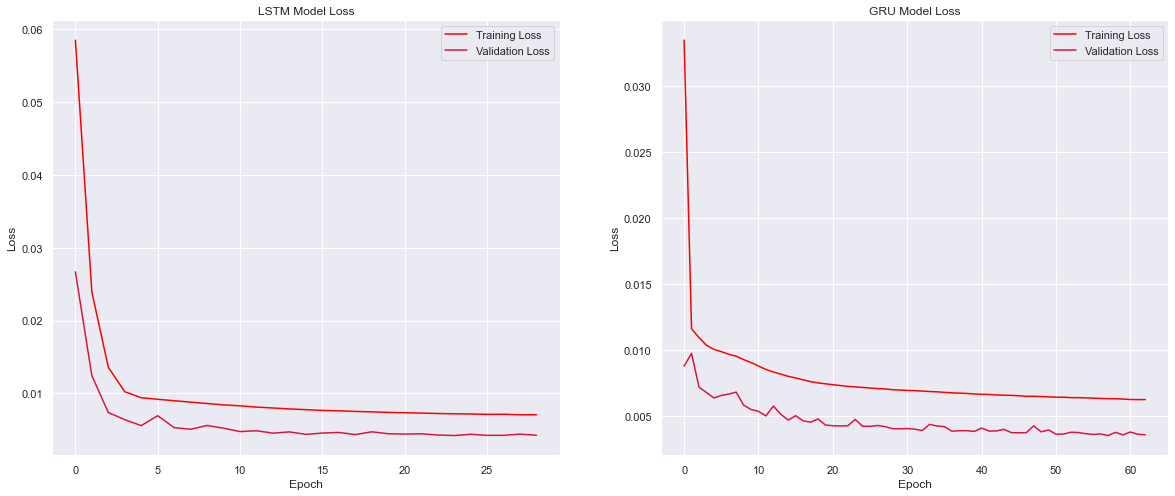

In [ ]:

# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(LSTM_history.history['loss'], color='red')
ax[0].plot(LSTM_history.history['val_loss'], color='crimson')
ax[0].set_title('LSTM Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(GRU_history.history['loss'], color='red')
ax[1].plot(GRU_history.history['val_loss'], color='crimson')
ax[1].set_title('GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig(path+"reduced_feature_images/training_loss.png", dpi=1200)
plt.show()

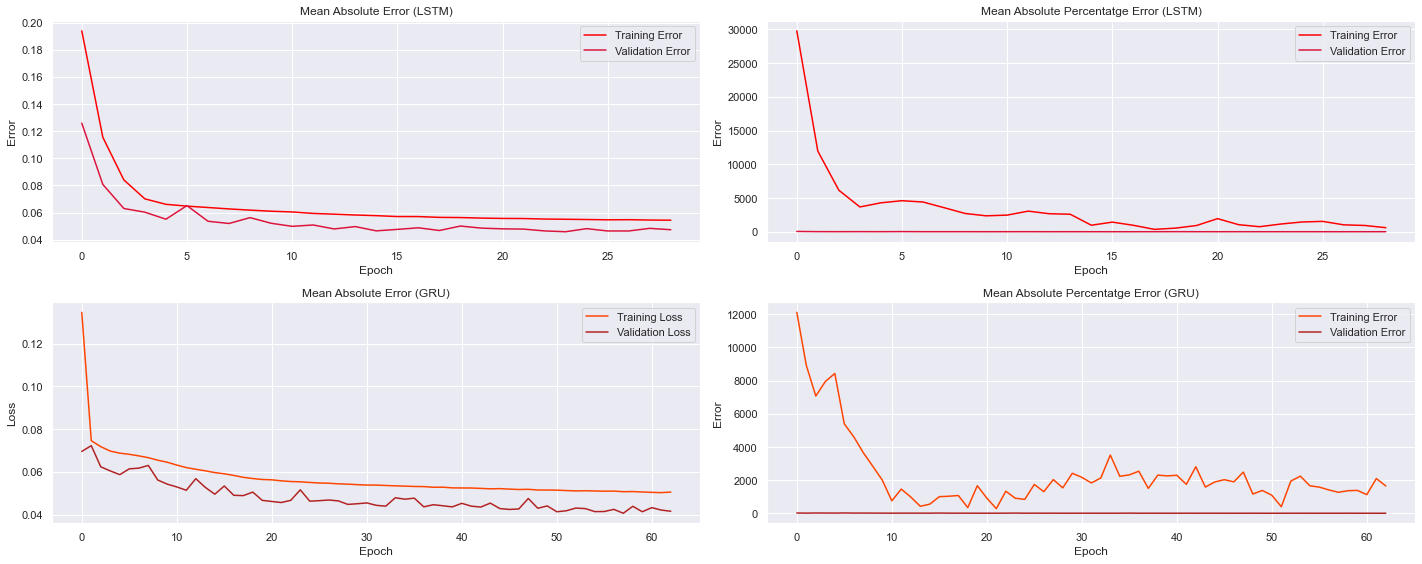

In [ ]:
# summarize history for loss
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0][0].plot(LSTM_history.history['mean_absolute_error'], color='red')
ax[0][0].plot(LSTM_history.history['val_mean_absolute_error'], color='crimson')
ax[0][0].set_title('Mean Absolute Error (LSTM)')
ax[0][0].set_ylabel('Error')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend(['Training Error', 'Validation Error'], loc='upper right')

ax[0][1].plot(LSTM_history.history['mean_absolute_percentage_error'], color='red')
ax[0][1].plot(LSTM_history.history['val_mean_absolute_percentage_error'], color='crimson')
ax[0][1].set_title('Mean Absolute Percentatge Error (LSTM)')
ax[0][1].set_ylabel('Error')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend(['Training Error', 'Validation Error'], loc='upper right')


ax[1][0].plot(GRU_history.history['mean_absolute_error'], color='orangered')
ax[1][0].plot(GRU_history.history['val_mean_absolute_error'], color='firebrick')
ax[1][0].set_title('Mean Absolute Error (GRU)')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1][1].plot(GRU_history.history['mean_absolute_percentage_error'], color='orangered')
ax[1][1].plot(GRU_history.history['val_mean_absolute_percentage_error'], color='firebrick')
ax[1][1].set_title('Mean Absolute Percentatge Error (GRU)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Epoch')
ax[1][1].legend(['Training Error', 'Validation Error'], loc='upper right')
fig.tight_layout()
plt.savefig(path+"reduced_feature_images/mean_absolute_error_loss.png", dpi=600)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
lstm_model = load_model(path+'reduced_feature_model/model_lstm/')
gru_model = load_model(path+'reduced_feature_model/model_gru/')

In [ ]:
lstm_prediction = lstm_model.predict(X_test)
gru_prediction = gru_model.predict(X_test)

238/238 [==============================] - 3s 7ms/step


In [ ]:
from tabnanny import verbose


lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_evaluation = gru_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
(lstm_evaluation, gru_evaluation)

([0.004959447775036097, 0.04939325153827667, 15919.685546875],
 [0.004567787516862154, 0.045024797320365906, 5975.7392578125])

In [ ]:
print(f'LSTM: Loss: {np.round(lstm_evaluation[0],4)}, Mean Absolute Error: {np.round(lstm_evaluation[1],4)}, MAPE: {np.round(lstm_evaluation[2],4)}')
print(f'GRU: Loss: {np.round(gru_evaluation[0],4)}, Mean Absolute Error: {np.round(gru_evaluation[1],4)}, MAPE: {np.round(gru_evaluation[2],4)}')

LSTM: Loss: 0.005, Mean Absolute Error: 0.0494, MAPE: 15919.6855
GRU: Loss: 0.0046, Mean Absolute Error: 0.045, MAPE: 5975.7393


In [ ]:
lstm_Y = np.repeat(lstm_prediction, num_of_feature, axis=1)
lstm_y_inverse = sc_test.inverse_transform(lstm_Y)
gru_Y = np.repeat(gru_prediction, num_of_feature, axis=1)
gru_y_inverse = sc_test.inverse_transform(gru_Y)

In [ ]:
Y_test = np.repeat(y_test, num_of_feature)
Y_test = Y_test.reshape(-1,num_of_feature)
Y_Test_transfer = sc_test.inverse_transform(Y_test)

In [ ]:
lstm_Y_pred = lstm_y_inverse[:, num_of_feature-1]
gru_Y_pred = gru_y_inverse[:,num_of_feature-1]
actual_Y_test = Y_Test_transfer[:,num_of_feature-1 ]

In [ ]:
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.plot(time[start:end], series_true[start:end],format)
    plt.plot(time[start:end], series_pred[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)
    plt.show()

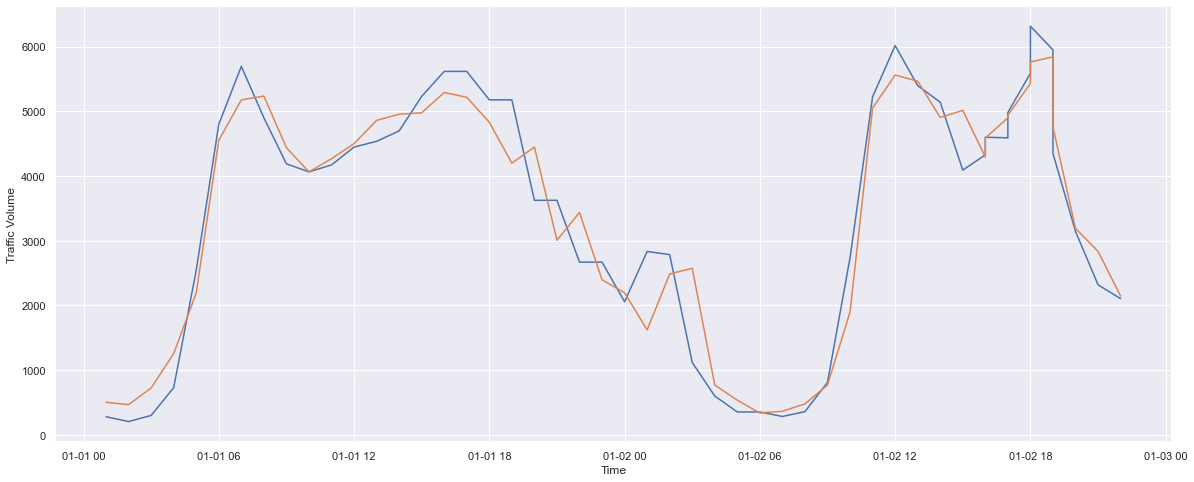

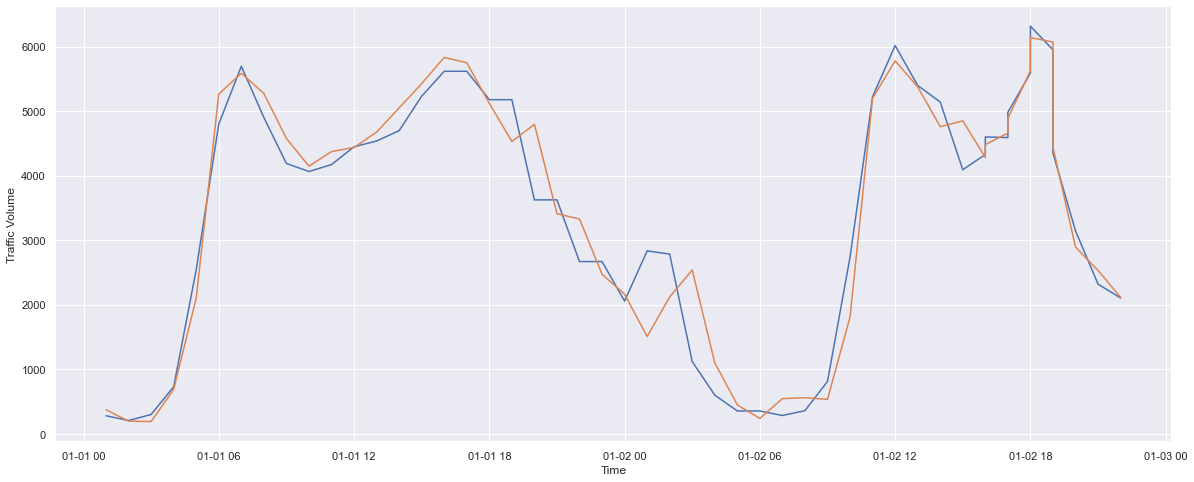

In [ ]:
lstm_y_pred = np.array(lstm_Y_pred)
gru_y_pred = np.array(gru_Y_pred)
y_true = np.array(actual_Y_test)

time_test = np.array(test_time)

plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],lstm_y_pred[:50])
plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],gru_y_pred[:50])

In [ ]:
def plot_series_subplot(time, series_true, series_pred, ax,title="",format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    ax.plot(time[start:end], series_true[start:end],format)
    ax.plot(time[start:end], series_pred[start:end],format)
    ax.set_xlabel('Time')
    ax.set_title(title)
    #ax.set_xticks(time[start:end])
    ax.set_xticklabels(xlabels, rotation=50)
    ax.legend(['Actual','Predicted'], loc='best')
    ax.set_ylabel('Traffic Volume')
    ax.grid(True)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


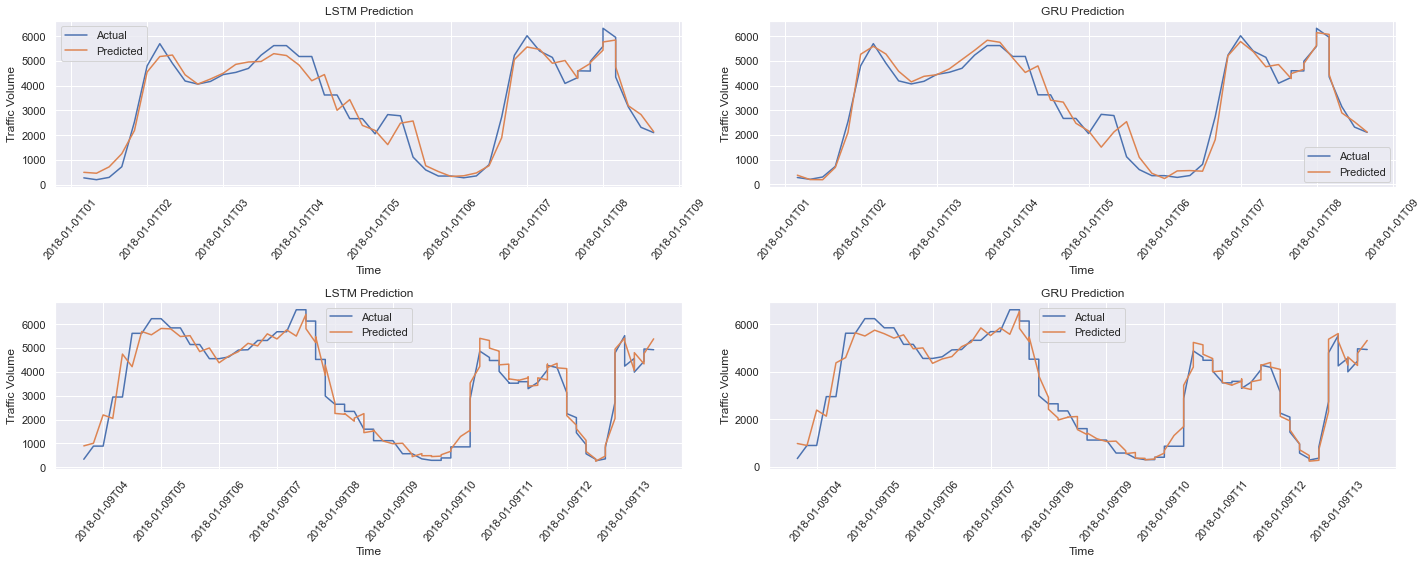

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],lstm_y_pred[:50],ax[0][0], "LSTM Prediction")
#plt.figure(figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],gru_y_pred[:50], ax[0][1],"GRU Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],lstm_y_pred[200:300],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],gru_y_pred[200:300], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"reduced_feature_images/prediction.png", dpi=600)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


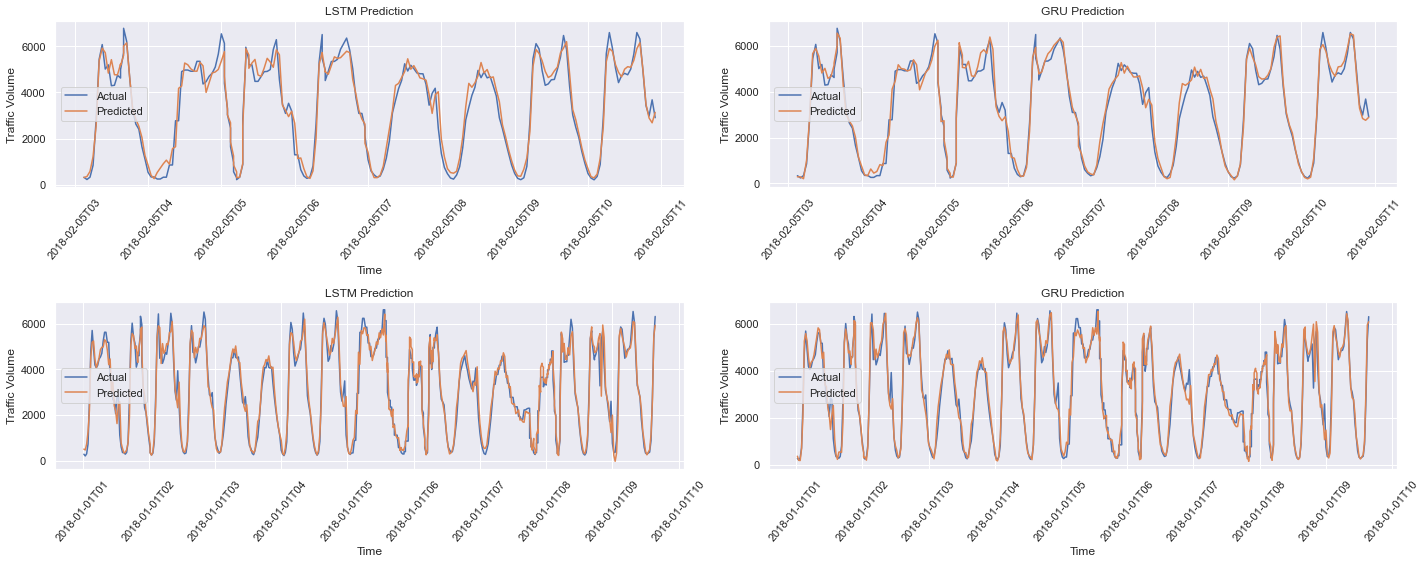

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],lstm_y_pred[1000:1200],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],gru_y_pred[1000:1200], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[0:500], y_true[0:500],lstm_y_pred[0:500],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[0:500], y_true[0:500],gru_y_pred[0:500], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"reduced_feature_images/prediction_1.png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


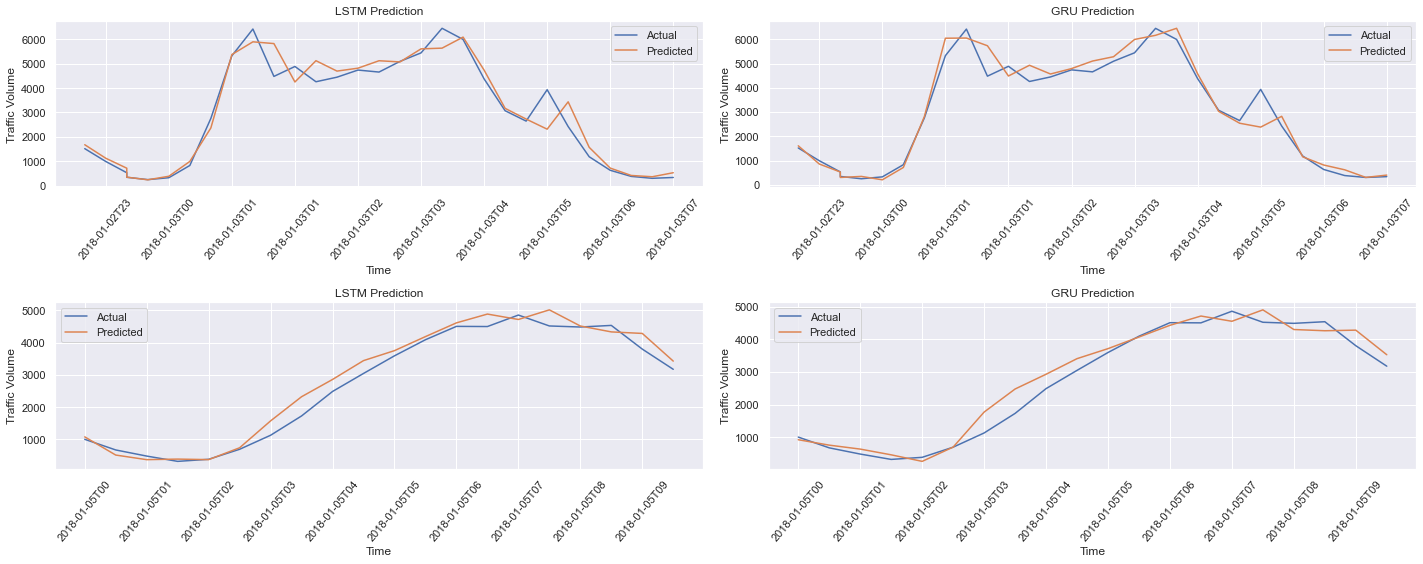

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[100:120], y_true[100:120],lstm_y_pred[100:120],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[100:120], y_true[100:120],gru_y_pred[100:120], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"reduced_feature_images/prediction_2.png", dpi=600)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_15552\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


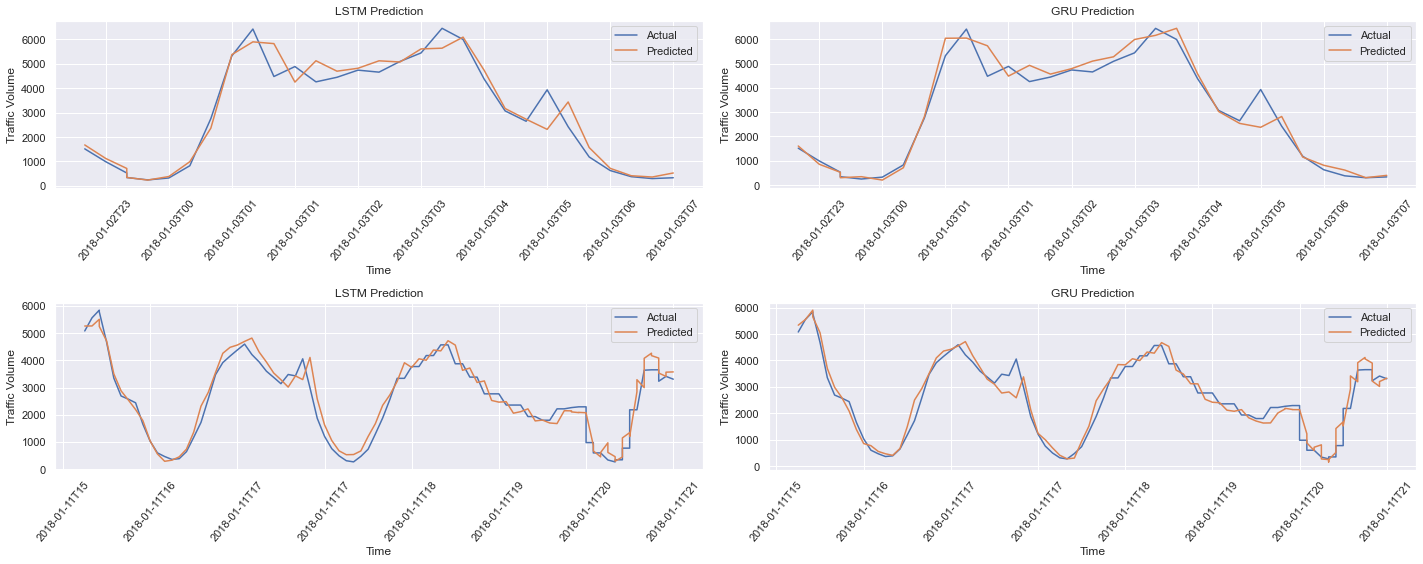

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[300:400], y_true[300:400],lstm_y_pred[300:400],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[300:400], y_true[300:400],gru_y_pred[300:400], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"reduced_feature_images/prediction_3.png", dpi=600)